In [10]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

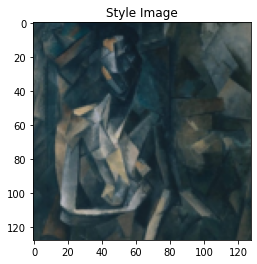

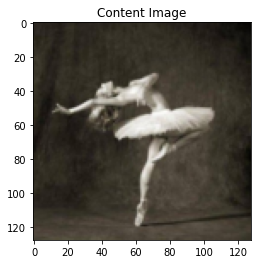

In [12]:
# 所需的输出图像大小
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("../data/neural-style/picasso.jpg")
content_img = image_loader("../data/neural-style/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
# 现在，让我们创建一个方法，通过重新将图片转换成PIL格式来展示，并使用plt.imshow展示它的拷贝。我们将尝试展示内容和风格图片来确保它们被正确的导入。

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

内容损失

In [13]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 我们从用于动态计算梯度的树中“分离”目标内容：
        # 这是一个声明的值，而不是变量。 
        # 否则标准的正向方法将引发错误。
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


Gram矩阵

In [14]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # 特征映射 b=number
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # 我们通过除以每个特征映射中的元素数来“标准化”gram矩阵的值.
    return G.div(a * b * c * d)

风格损失

In [15]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [16]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\a1311/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [02:26<00:00, 3.92MB/s] 


In [17]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 创建一个模块来规范化输入图像
# 这样我们就可以轻松地将它放入nn.Sequential中
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [18]:
# 期望的深度层来计算样式/内容损失：
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # 规范化模块
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # 只是为了拥有可迭代的访问权限或列出内容/系统损失
    content_losses = []
    style_losses = []

    # 假设cnn是一个`nn.Sequential`，
    # 所以我们创建一个新的`nn.Sequential`来放入应该按顺序激活的模块
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # 对于我们在下面插入的`ContentLoss`和`StyleLoss`，
            # 本地版本不能很好地发挥作用。所以我们在这里替换不合适的
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # 加入内容损失:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # 加入风格损失:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 现在我们在最后的内容和风格损失之后剪掉了图层
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

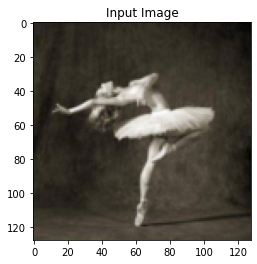

In [19]:
input_img = content_img.clone()
# 如果您想使用白噪声而取消注释以下行：
# input_img = torch.randn(content_img.data.size(), device=device)

# 将原始输入图像添加到图中：
plt.figure()
imshow(input_img, title='Input Image')

In [20]:
def get_input_optimizer(input_img):
    # 此行显示输入是需要渐变的参数
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [21]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 更正更新的输入图像的值
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 最后的修正......
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


C:\Users\a1311\AppData\Local\Temp/ipykernel_5692/2786996011.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\a1311\AppData\Local\Temp/ipykernel_5692/2786996011.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 108.029129 Content Loss: 17.845634

run [100]:
Style Loss : 24.519272 Content Loss: 16.099222

run [150]:
Style Loss : 10.290849 Content Loss: 14.315218

run [200]:
Style Loss : 5.461879 Content Loss: 12.580855

run [250]:
Style Loss : 3.504187 Content Loss: 11.140999

run [300]:
Style Loss : 2.701463 Content Loss: 10.010153



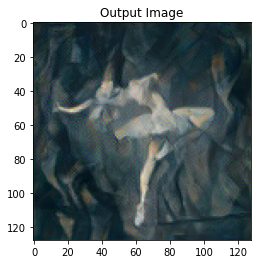

In [22]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()